In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Read datasets

In [5]:
fake = pd.read_csv("https://raw.githubusercontent.com/SushwanthReddy/Fake-News-Detection-using-Machine-Learning/master/data/Fake.csv")

In [6]:
true = pd.read_csv("https://raw.githubusercontent.com/SushwanthReddy/Fake-News-Detection-using-Machine-Learning/master/data/True.csv")


In [7]:
fake.shape

(23481, 4)

In [8]:
true.shape

(21417, 4)

# Data cleaning and preparation

In [9]:
# Add target columns for fake and true
fake['target'] = 0
true['target'] = 1

In [10]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [11]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [12]:
# check the data 

data.head()

,title,text,subject,date,target
0,Syria deal may be on agenda for Putin-Trump As...,MOSCOW (Reuters) - Russian President Vladimir ...,worldnews,"November 4, 2017",1
1,"One U.S. attack is not enough, says Syrian opp...",BEIRUT (Reuters) - The Syrian opposition appla...,politicsNews,"April 7, 2017",1
2,United States and Cuba complete deals as Trump...,HAVANA (Reuters) - The Obama administration an...,politicsNews,"January 18, 2017",1
3,Syrian government envoy: U.S. and Turkish troo...,"ASTANA (Reuters) - Syria s U.N. ambassador, Ba...",worldnews,"December 22, 2017",1
4,Russia frees two pro-Kiev Crimea Tatar leaders...,MOSCOW (Reuters) - Russia has freed two promin...,worldnews,"October 25, 2017",1


In [13]:
# Removing the date (we are not using it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Syria deal may be on agenda for Putin-Trump As...,MOSCOW (Reuters) - Russian President Vladimir ...,worldnews,1
1,"One U.S. attack is not enough, says Syrian opp...",BEIRUT (Reuters) - The Syrian opposition appla...,politicsNews,1
2,United States and Cuba complete deals as Trump...,HAVANA (Reuters) - The Obama administration an...,politicsNews,1
3,Syrian government envoy: U.S. and Turkish troo...,"ASTANA (Reuters) - Syria s U.N. ambassador, Ba...",worldnews,1
4,Russia frees two pro-Kiev Crimea Tatar leaders...,MOSCOW (Reuters) - Russia has freed two promin...,worldnews,1


In [14]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,MOSCOW (Reuters) - Russian President Vladimir ...,worldnews,1
1,BEIRUT (Reuters) - The Syrian opposition appla...,politicsNews,1
2,HAVANA (Reuters) - The Obama administration an...,politicsNews,1
3,"ASTANA (Reuters) - Syria s U.N. ambassador, Ba...",worldnews,1
4,MOSCOW (Reuters) - Russia has freed two promin...,worldnews,1


In [15]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,moscow (reuters) - russian president vladimir ...,worldnews,1
1,beirut (reuters) - the syrian opposition appla...,politicsNews,1
2,havana (reuters) - the obama administration an...,politicsNews,1
3,"astana (reuters) - syria s u.n. ambassador, ba...",worldnews,1
4,moscow (reuters) - russia has freed two promin...,worldnews,1


In [16]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [17]:
# Check
data.head()

,text,subject,target
0,moscow reuters russian president vladimir put...,worldnews,1
1,beirut reuters the syrian opposition applaude...,politicsNews,1
2,havana reuters the obama administration and c...,politicsNews,1
3,astana reuters syria s un ambassador bashar a...,worldnews,1
4,moscow reuters russia has freed two prominent...,worldnews,1


In [18]:
import warnings

warnings.filterwarnings('ignore')

In [19]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
data.head()

,text,subject,target
0,moscow reuters russian president vladimir puti...,worldnews,1
1,beirut reuters syrian opposition applauded us ...,politicsNews,1
2,havana reuters obama administration cuba conti...,politicsNews,1
3,astana reuters syria un ambassador bashar alja...,worldnews,1
4,moscow reuters russia freed two prominent crim...,worldnews,1


In [21]:
# checking null values

data.isnull().sum()

text       0
subject    0
target     0
dtype: int64

# EDA

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


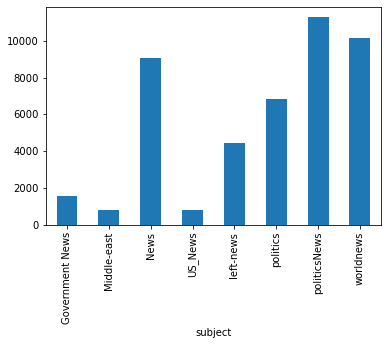

In [22]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
0    23481
1    21417
Name: text, dtype: int64


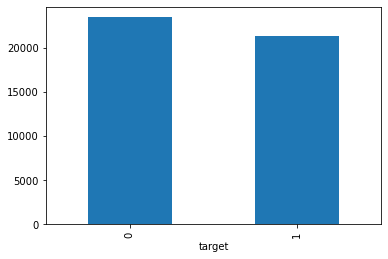

In [23]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [24]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

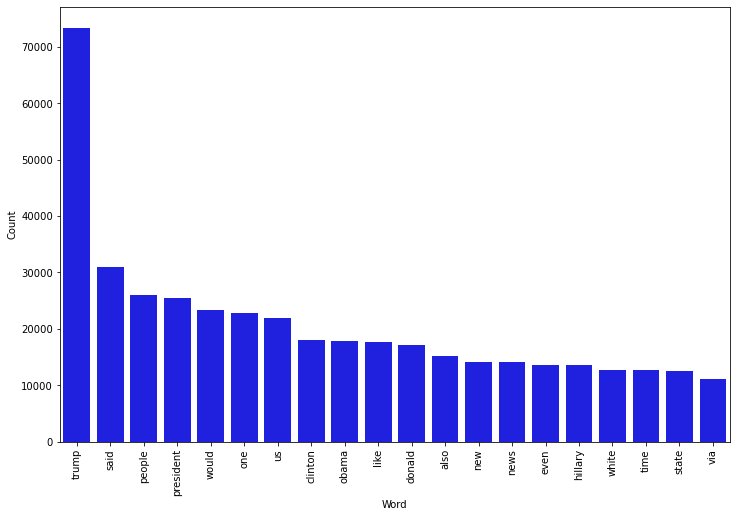

In [25]:
# Most frequent words in fake news
counter(data[data["target"] == 0], "text", 20)

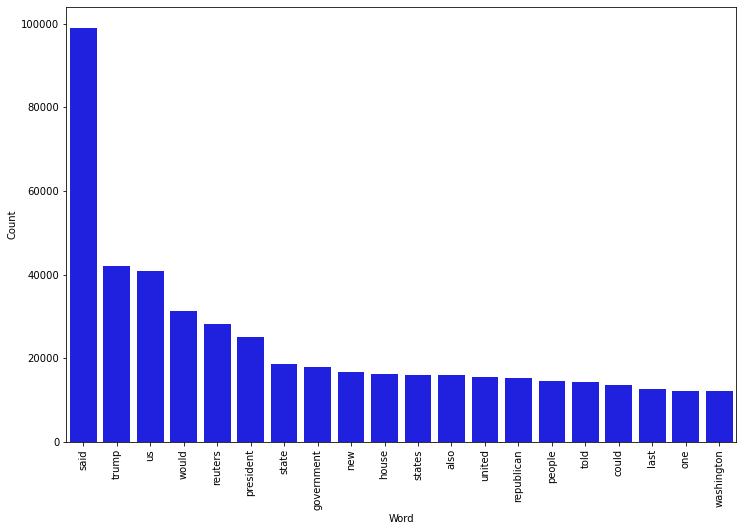

In [26]:
# Most frequent words in real news
counter(data[data["target"] == 1], "text", 20)

# Model building

In [27]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Peparing the data


In [28]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# Naive Bayes

In [29]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 95.13%


Confusion matrix, without normalization


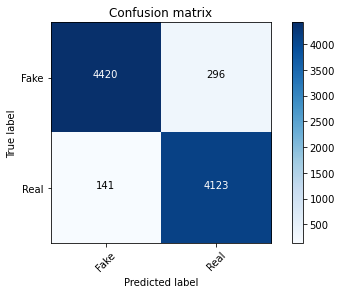

In [30]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Logistic regression

In [31]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 98.83%


Confusion matrix, without normalization


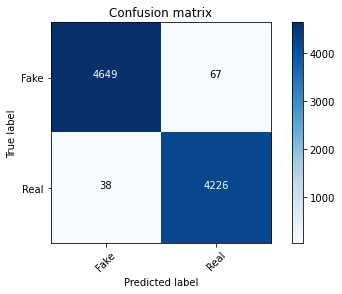

In [32]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.67%


Confusion matrix, without normalization


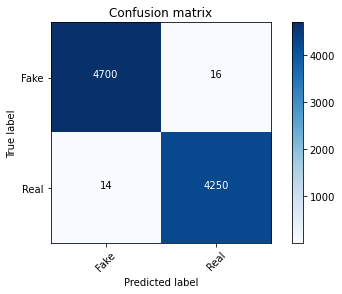

In [34]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Random Forest


In [35]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.05%


Confusion matrix, without normalization


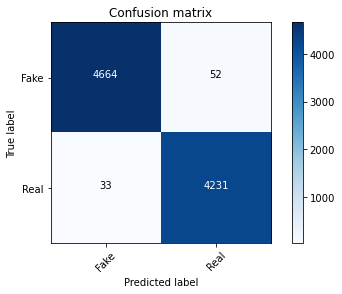

In [36]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Comparing Different Models

([<matplotlib.axis.YTick at 0x22757e7f160>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

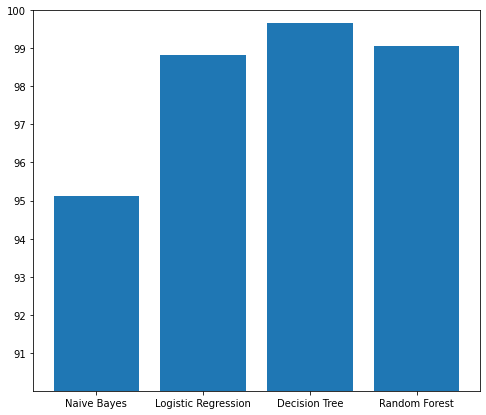

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

([<matplotlib.axis.YTick at 0x22757eb4eb0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

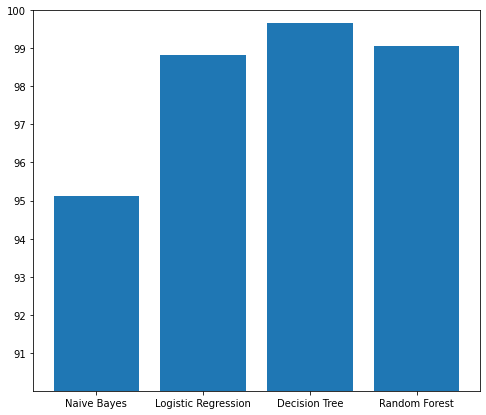

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

# conclusion :

we have applied many algorithm like (Naive Bayes , Logistic Regression,Decision Tree ,Random Forest ). but as we can see that Decision Tree has given the best accuracy score  